# Import modules

In [1]:
import os
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import getpass
import glob
import seaborn as sns
import functions
import lfp_pre_processing_functions
import power_functions
import coherence_functions
import spectrogram_plotting_functions
import plotting_styles
import scipy.stats
import mne_connectivity
import mne
import json

importlib.reload(functions) #loads our custom made functions.py file
importlib.reload(spectrogram_plotting_functions)
importlib.reload(plotting_styles)

linestyle = plotting_styles.linestyles
colors = plotting_styles.colors

# Loading Files and Savepath

In [4]:
#Fetch the current user
user= (getpass.getuser())
print("Hello", user)

if user == 'CPLab':
    base='D:\\Dropbox\\CPLab'
else:
    base='C:\\Users\\{}\\Dropbox\\CPLab'.format(user)
#Set the basepath, savepath and load the data files
files = glob.glob(base+'\\all_data_mat_250825\\*.mat')
savepath = base+'\\results\\'
print("Base path:", base)
print("Save path:", savepath)
print(files)

time_window = 1
fs= 2000

Hello CPLab
Base path: D:\Dropbox\CPLab
Save path: D:\Dropbox\CPLab\results\
['D:\\Dropbox\\CPLab\\all_data_mat_250825\\20230529_dk1_nocontext.mat', 'D:\\Dropbox\\CPLab\\all_data_mat_250825\\20230529_dk3_nocontext.mat', 'D:\\Dropbox\\CPLab\\all_data_mat_250825\\20230529_dk5_nocontext.mat', 'D:\\Dropbox\\CPLab\\all_data_mat_250825\\20230529_dk6_nocontext.mat', 'D:\\Dropbox\\CPLab\\all_data_mat_250825\\20230531_dk1_nocontext_day2.mat', 'D:\\Dropbox\\CPLab\\all_data_mat_250825\\20230531_dk3_nocontext_day2.mat', 'D:\\Dropbox\\CPLab\\all_data_mat_250825\\20230531_dk5_nocontext_day2.mat', 'D:\\Dropbox\\CPLab\\all_data_mat_250825\\20230531_dk6_nocontext_day2.mat', 'D:\\Dropbox\\CPLab\\all_data_mat_250825\\20230609_dk1_BW_nocontext_day1.mat', 'D:\\Dropbox\\CPLab\\all_data_mat_250825\\20230609_dk3_BW_nocontext_day1.mat', 'D:\\Dropbox\\CPLab\\all_data_mat_250825\\20230610_dk1_BW_nocontext_day2.mat', 'D:\\Dropbox\\CPLab\\all_data_mat_250825\\20230610_dk3_BW_nocontext_day2.mat', 'D:\\Dropbox\\CPLa

# Creating MNE Epochs Array

In [6]:

importlib.reload(lfp_pre_processing_functions)
#files=[f'C:\\Users\\{user}\\Dropbox\\CPLab\\all_data_mat\\20230616_dk6_BW_context_day2.mat']
event_data_df=[]
con_data_df=[]

con_data_df_shuffled=[]
shuffled_event_data_df=[]
events_codes_all = {}
random_baseline_data=[]
baseline_lfp_all=[]



files_short=[files[10]] ### TEST CHANGE THIS 


for file_num,file in enumerate(files):
    #if 'dk1' in file:
        
        #print(file)
        base_name = os.path.basename(file)
        base_name, _ = os.path.splitext(base_name)

        date, rat_id, task = lfp_pre_processing_functions.exp_params(base_name)
        print(date, rat_id, task)
        if task == 'nocontextday2' or task == 'nocontextos2':
            task = 'nocontext'
        if task =='nocontext':
            continue
        # if rat_id=='dk1': #REMOVING DK1 TEMPORARLILY . PLEASE CHANGE LATER
        #     continue
        f = h5py.File(file, 'r')
        channels = list(f.keys())
        #print(channels)
         
        if not any("AON" in channel or "vHp" in channel for channel in channels):
            print("No AON or vHp channels in this file")
            continue

        events,reference_electrode=lfp_pre_processing_functions.get_keyboard_and_ref_channels(f,channels)

    #finding global start and end time of all channels, since they start and end recordings at different times
        global_start_time, global_end_time=lfp_pre_processing_functions.find_global_start_end_times(f,channels)
        
        ## Reference electrode finding and padding
        reference_time = np.array(reference_electrode['times']).flatten()
        reference_value = np.array(reference_electrode['values']).flatten()
        padd_ref_data,padded_ref_time=lfp_pre_processing_functions.pad_raw_data_raw_time(reference_value,reference_time,global_start_time,global_end_time,sampling_rate=2000)

        events_codes = np.array(events['codes'][0])
        events_times = np.array(events['times'][0])
        events_codes_all[base_name] = events_codes
        epochs = lfp_pre_processing_functions.generate_epochs_with_first_event(events_codes, events_times)
        #epochs = functions.generate_specific_num_of_epochs_with_first_event(events_codes, events_times,5)
        aon_lfp_channels=[x for x in channels if 'AON' in x ]
        vHp_lfp_channels=[x for x in channels if 'vHp' in x ]
        all_channels=np.concatenate((aon_lfp_channels,vHp_lfp_channels))
        #print(all_channels)
        
        mne_baseline_data=np.zeros((1,len(all_channels),4000))
        mne_epoch_door_before=np.zeros((len(epochs),len(all_channels),int(time_window*fs)))
        mne_epoch_door_after=np.zeros((len(epochs),len(all_channels),int(time_window*fs)))
        mne_epoch_dig_before=np.zeros((len(epochs),len(all_channels),int(time_window*fs)))
        mne_epoch_dig_after=np.zeros((len(epochs),len(all_channels),int(time_window*fs)))
        mne_epoch_around_door=np.zeros((len(epochs),len(all_channels),int(time_window*fs)*2))
        mne_epoch_around_dig=np.zeros((len(epochs),len(all_channels),int(time_window*fs)*2))
        
        print(f'File {rat_id} {task} {date} has {len(epochs)} epochs and {len(all_channels)} channels')

            # NEW: Create metadata dictionary to store epoch information
        metadata_dict = {
            'door_timestamp': [],
            'dig_timestamp': [],
            'time_to_dig': [],
            'trial_type': [],
            'dig_type': []
        }

        first_event = events_times[0]
        
        for channel_num,channeli in enumerate(all_channels):
            if "AON" in channeli or "vHp" in channeli:
                channel_id = channeli
                data_all = f[channeli]
                raw_data = np.array(data_all['values']).flatten()
                raw_time = np.array(data_all['times']).flatten()
                sampling_rate = int(1 / data_all['interval'][0][0])
                #print(raw_data.shape, raw_time.shape, sampling_rate)
                padded_data,padded_time=lfp_pre_processing_functions.pad_raw_data_raw_time(raw_data,raw_time,global_start_time,global_end_time,sampling_rate)
                subtracted_data = padded_data - padd_ref_data
                raw_data=subtracted_data
                notch_filtered_data = lfp_pre_processing_functions.iir_notch(raw_data, sampling_rate, 60)

                data_before, time, baseline_mean, baseline_std=lfp_pre_processing_functions.baseline_data_normalization(notch_filtered_data, raw_time, first_event, sampling_rate)
                first_event_index=np.where(raw_time>first_event)[0][0]

                mne_baseline_data[0,channel_num,:]=list(data_before)
                total = notch_filtered_data

                
                for i, epochi in enumerate(epochs):
                    door_timestamp = epochi[0][0]
                    trial_type = epochi[0][1]
                    dig_type = epochi[1, 1]
                    #print(dig_type)
                    dig_timestamp = epochi[1, 0]
                    #print(door_timestamp, trial_type, dig_timestamp, dig_type)
                    
                    # NEW: Store metadata only once per epoch (on first channel iteration)
                    if channel_num == 0:
                        metadata_dict['door_timestamp'].append(door_timestamp)
                        metadata_dict['dig_timestamp'].append(dig_timestamp)
                        metadata_dict['time_to_dig'].append(dig_timestamp - door_timestamp)
                        metadata_dict['trial_type'].append(trial_type)
                        metadata_dict['dig_type'].append(dig_type)
                    
                    
                    
                    data_trial_before, data_trial_after=lfp_pre_processing_functions.extract_event_data(notch_filtered_data,time,door_timestamp,sampling_rate,truncation_time=time_window)
                    data_dig_before, data_dig_after=lfp_pre_processing_functions.extract_event_data(notch_filtered_data,time,dig_timestamp,sampling_rate,truncation_time=time_window)
                    data_around_door=np.concatenate((data_trial_before, data_trial_after))
                    data_around_dig=np.concatenate((data_dig_before, data_dig_after))

                    epoch_data = [data_trial_before, data_trial_after, data_dig_before, data_dig_after, data_around_door, data_around_dig]
                    event_data_list = [lfp_pre_processing_functions.zscore_event_data(x, baseline_std) for x in epoch_data]

                    mne_epoch_door_before[i,channel_num,:]=list(event_data_list[0][-int(time_window*fs):])
                    mne_epoch_door_after[i,channel_num,:]=list(event_data_list[1][:int(time_window*fs)])
                    mne_epoch_dig_before[i,channel_num,:]=list(event_data_list[2][-int(time_window*fs):])
                    mne_epoch_dig_after[i,channel_num,:]=list(event_data_list[3][:int(time_window*fs)])
                    mid_point = int(len(event_data_list[4]) / 2)
                    mne_epoch_around_door[i,channel_num,:]=list(event_data_list[4][mid_point-int(time_window*fs):mid_point+int(time_window*fs)])
                    mne_epoch_around_dig[i,channel_num,:]=list(event_data_list[5][mid_point-int(time_window*fs):mid_point+int(time_window*fs)])

        if len(all_channels)>0:
            fs=2000
            freqs = np.arange(1,100)
            n_cycles = freqs/3
            info = mne.create_info(ch_names=list(all_channels), sfreq=fs, ch_types='eeg')
            
            metadata_df = pd.DataFrame(metadata_dict)
            
            mne_baseline = mne.EpochsArray(mne_baseline_data, info)
            
            # NEW: Create EpochsArray objects WITH metadata
            mne_epoch_door_before = mne.EpochsArray(mne_epoch_door_before, info, metadata=metadata_df)
            mne_epoch_door_after = mne.EpochsArray(mne_epoch_door_after, info, metadata=metadata_df)
            mne_epoch_dig_before = mne.EpochsArray(mne_epoch_dig_before, info, metadata=metadata_df)
            mne_epoch_dig_after = mne.EpochsArray(mne_epoch_dig_after, info, metadata=metadata_df)
            mne_epoch_around_door = mne.EpochsArray(mne_epoch_around_door, info, metadata=metadata_df)
            mne_epoch_around_dig = mne.EpochsArray(mne_epoch_around_dig, info, metadata=metadata_df)
            
            row_list=[file_num,date,rat_id,task,mne_baseline,mne_epoch_door_before,mne_epoch_door_after,mne_epoch_dig_before,mne_epoch_dig_after,mne_epoch_around_door,mne_epoch_around_dig]
            con_data_df.append(row_list)

con_data_df=pd.DataFrame(con_data_df, columns=['experiment','date','rat_id','task','mne_baseline','mne_epoch_door_before','mne_epoch_door_after','mne_epoch_dig_before','mne_epoch_dig_after','mne_epoch_around_door','mne_epoch_around_dig'])
con_data_df.to_pickle(savepath+f'mne_epochs_array_df_truncated_{int(time_window*fs)}.pkl')

20230529 dk1 nocontext
20230529 dk3 nocontext
20230529 dk5 nocontext
20230529 dk6 nocontext
20230531 dk1 nocontextday2
20230531 dk3 nocontextday2
20230531 dk5 nocontextday2
20230531 dk6 nocontextday2
20230609 dk1 BWnocontext
Global start time: 0.0, Global end time: 1980.2432749999998
3960487
start_index: 0, end_index: 3960486
File dk1 BWnocontext 20230609 has 20 epochs and 4 channels
3960487
start_index: 0, end_index: 3960487
notch filter applied
normalizing data
3960487
start_index: 0, end_index: 3960487
notch filter applied
normalizing data
3960487
start_index: 0, end_index: 3960487
notch filter applied
normalizing data
3960487
start_index: 0, end_index: 3960487
notch filter applied
normalizing data
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 5 columns
20 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 5 columns
20 matching events found
No baseline 

## Dropping bad epochs

In [7]:
import json
annotated_file = pd.read_csv(savepath+'con_data_df_annotation.csv')
con_data_df=pd.read_pickle(savepath+f'mne_epochs_array_df_truncated_{int(time_window*fs)}.pkl')
print(annotated_file.columns)
print(con_data_df.columns)
for rowi in range(annotated_file.shape[0]):
    experiment=annotated_file.loc[rowi, 'experiment']
    rat_id = annotated_file.loc[rowi,'rat_id']
    task=annotated_file.loc[rowi,'task']
    date=annotated_file.loc[rowi,'date']
    
    con_data_exp = con_data_df[(con_data_df['experiment']==experiment) & (con_data_df['rat_id']==rat_id) & (con_data_df['task']==task) &(con_data_df['task']==task)]

    annotation_door_before = np.array(json.loads(annotated_file.loc[rowi, 'annotation_door_before']))
    annotation_dig_before = np.array(json.loads(annotated_file.loc[rowi, 'annotation_dig_before']))
    annotation_dig_after = np.array(json.loads(annotated_file.loc[rowi, 'annotation_dig_after']))

    print(annotation_door_before[0])
    con_data_exp['mne_epoch_door_before'].iloc[0].drop(annotation_door_before, reason = "bad")
    con_data_exp['mne_epoch_dig_before'].iloc[0].drop(annotation_dig_before, reason = "bad")
    con_data_exp['mne_epoch_dig_after'].iloc[0].drop(annotation_dig_after, reason = "bad")
con_data_df.to_pickle(savepath +f'marked_mne_epochs_array_{int(time_window*fs)}.pkl')

Index(['experiment', 'date', 'rat_id', 'task', 'Unnamed: 4',
       'mne_epoch_door_before', 'annotation_door_before',
       'mne_epoch_dig_before', 'annotation_dig_before', 'mne_epoch_dig_after',
       'annotation_dig_after', 'Unnamed: 11', 'Unnamed: 12'],
      dtype='object')
Index(['experiment', 'date', 'rat_id', 'task', 'mne_baseline',
       'mne_epoch_door_before', 'mne_epoch_door_after', 'mne_epoch_dig_before',
       'mne_epoch_dig_after', 'mne_epoch_around_door', 'mne_epoch_around_dig'],
      dtype='object')
11
Dropped 1 epoch: 11
Dropped 6 epochs: 2, 8, 9, 10, 15, 17
Dropped 4 epochs: 2, 9, 10, 12
4
Dropped 2 epochs: 4, 16
Dropped 8 epochs: 3, 10, 11, 12, 13, 14, 17, 18
Dropped 4 epochs: 0, 2, 15, 17
3
Dropped 5 epochs: 3, 7, 9, 10, 13
Dropped 2 epochs: 11, 15
Dropped 2 epochs: 14, 15
9
Dropped 1 epoch: 9
Dropped 3 epochs: 2, 7, 8
Dropped 3 epochs: 0, 7, 8
9
Dropped 8 epochs: 9, 10, 12, 13, 15, 16, 17, 19
Dropped 7 epochs: 0, 2, 3, 4, 12, 14, 17
Dropped 4 epochs: 0, 6, 7,

# Power analysis

## PSD

Index(['experiment', 'date', 'rat_id', 'task', 'mne_baseline',
       'mne_epoch_door_before', 'mne_epoch_door_after', 'mne_epoch_dig_before',
       'mne_epoch_dig_after', 'mne_epoch_around_door', 'mne_epoch_around_dig'],
      dtype='object')
Processing rat dk1, task BWnocontext, date 20230609 (1/27)
Processing rat dk3, task BWnocontext, date 20230609 (2/27)
Processing rat dk1, task BWnocontext, date 20230610 (3/27)
Processing rat dk3, task BWnocontext, date 20230610 (4/27)
Processing rat dk5, task BWcontext, date 20230615 (5/27)
Processing rat dk6, task BWcontext, date 20230615 (6/27)
Processing rat dk5, task BWcontext, date 20230616 (7/27)
Processing rat dk6, task BWcontext, date 20230616 (8/27)
Processing rat dk1, task BWcontext, date 20230623 (9/27)
Processing rat dk1, task BWcontext, date 20230626 (10/27)
Processing rat dk5, task BWnocontext, date 20230626 (11/27)
Processing rat dk6, task BWnocontext, date 20230626 (12/27)
Processing rat dk1, task BWcontext, date 20230627 (13/27

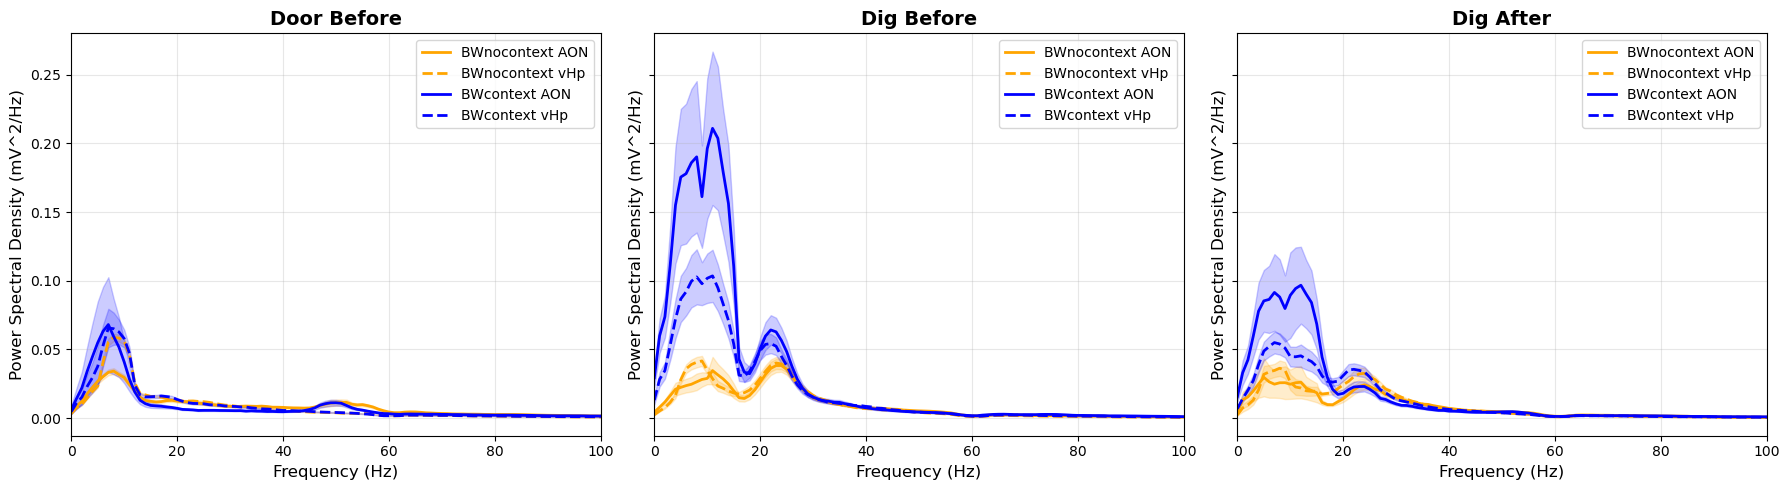


All done!


In [12]:
import pandas as pd
import numpy as np
from scipy import stats

con_data_df_clean = pd.read_pickle(savepath +f'marked_mne_epochs_array_{int(time_window*fs)}.pkl')
event_list = ['mne_epoch_door_before', 'mne_epoch_dig_before', 'mne_epoch_dig_after']

def get_channel_groups(channel_names, task):
    """
    Identify channel groups based on channel names and task.
    Returns dictionary with channel indices for each group.
    """
    aon_channels = [ch for ch in channel_names if 'AON' in ch]
    vhp_channels = [ch for ch in channel_names if 'vHp' in ch]
    
    groups = {
        f'{task}_AON': aon_channels,
        f'{task}_vHp': vhp_channels
    }
    
    return groups

print(con_data_df_clean.columns)

# Dictionary to store PSD data for each event and task combination
# Structure: event_psd_data[event][task][group_name] = list of (n_trials, n_freqs) arrays
event_psd_data = {event: {} for event in event_list}
freqs_array = None  # Will store frequency values

for i in range(len(con_data_df_clean)):
    rat = con_data_df_clean.loc[i, 'rat_id']
    task = con_data_df_clean.loc[i, 'task']
    date = con_data_df_clean.loc[i, 'date']
    
    print(f"Processing rat {rat}, task {task}, date {date} ({i+1}/{len(con_data_df_clean)})")
    
    for event in event_list:
        test_epoch = con_data_df_clean.loc[i, event]
        
        # Compute PSD
        test_epoch_psd = test_epoch.compute_psd(
            method='multitaper', 
            fmin=0, 
            fmax=100, 
            adaptive=True, 
            bandwidth=6, 
            normalization='full', 
            verbose=0,
            exclude=['Ref']
        )
        
        # Get PSD data and frequencies
        psd_array = test_epoch_psd.get_data()  # shape: (n_trials, n_channels, n_freqs)
        freqs = test_epoch_psd.freqs
        channel_names = test_epoch_psd.ch_names
        
        # Store frequency array (same for all)
        if freqs_array is None:
            freqs_array = freqs
        
        # Identify channel groups based on task and channel names
        channel_groups = get_channel_groups(channel_names, task)
        
        # Initialize task dictionary if needed
        if task not in event_psd_data[event]:
            event_psd_data[event][task] = {group: [] for group in channel_groups.keys()}
        
        # Process each channel group
        for group_name, group_channels in channel_groups.items():
            # Find indices of channels in this group
            channel_indices = [idx for idx, ch in enumerate(channel_names) 
                             if ch in group_channels]
            
            if len(channel_indices) > 0:
                # Get PSD data for these channels: (n_trials, n_channels_in_group, n_freqs)
                group_psd = psd_array[:, channel_indices, :]
                
                # Average across channels: (n_trials, n_freqs)
                group_psd_avg_channels = np.mean(group_psd, axis=1)
                
                # Store this rat's data
                event_psd_data[event][task][group_name].append(group_psd_avg_channels)

# Now aggregate across rats for each event and task
print("\nAggregating across rats...")
final_psd_dfs = {}

for event in event_list:
    # Dictionary to hold columns for this event
    df_dict = {'frequency': freqs_array}  # Add frequency column first
    
    # Get all tasks for this event
    for task in event_psd_data[event].keys():
        # Process each channel group
        for group_name in event_psd_data[event][task].keys():
            rat_data = event_psd_data[event][task][group_name]
            
            if len(rat_data) > 0:
                # rat_data is a list of (n_trials, n_freqs) arrays, one per rat
                # Concatenate all rats' trials: (total_trials_all_rats, n_freqs)
                all_trials = np.concatenate(rat_data, axis=0)
                
                # Calculate mean and SEM across all trials from all rats
                psd_mean = np.mean(all_trials, axis=0)
                psd_sem = stats.sem(all_trials, axis=0)
                
                # Add as columns
                df_dict[f'{group_name}_mean'] = psd_mean
                df_dict[f'{group_name}_sem'] = psd_sem
            else:
                df_dict[f'{group_name}_mean'] = np.full(len(freqs_array), np.nan)
                df_dict[f'{group_name}_sem'] = np.full(len(freqs_array), np.nan)
    
    # Create dataframe where each row is a frequency bin
    final_psd_dfs[event] = pd.DataFrame(df_dict)
    print(f"{event}: {len(final_psd_dfs[event])} frequency bins, {len(df_dict)} columns")

# Save PSD Mean/SEM to Excel
excel_filename_psd = savepath + f'pow_events_psd_{int(time_window*fs/2)}ms.xlsx'
print(f"\nSaving PSD mean/SEM to {excel_filename_psd}...")

with pd.ExcelWriter(excel_filename_psd, engine='openpyxl') as writer:
    for event, df in final_psd_dfs.items():
        sheet_name = event.replace('mne_epoch_', '')[:31]
        df.to_excel(writer, sheet_name=sheet_name, index=False)
        print(f"Saved sheet: {sheet_name} ({len(df)} rows, {len(df.columns)} columns)")

print("\nPSD Mean/SEM Analysis Done!")

# Display sample
print("\n=== PSD Mean/SEM Sample ===")
for event, df in final_psd_dfs.items():
    print(f"\n{event}:")
    print(df.head(10))
    print(f"Shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")


# ===== Plotting =====
print("\nCreating plots...")

# Create figure with 3 subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Event titles for subplots
event_titles = {
    'mne_epoch_door_before': 'Door Before',
    'mne_epoch_dig_before': 'Dig Before',
    'mne_epoch_dig_after': 'Dig After'
}

for idx, event in enumerate(event_list):
    ax = axes[idx]
    df = final_psd_dfs[event]
    freqs = df['frequency'].values
    
    # Get all column names except frequency
    data_columns = [col for col in df.columns if col != 'frequency']
    
    # Extract task and region from column names and plot
    plotted_lines = []
    for col in data_columns:
        if '_mean' in col:
            # Parse column name: e.g., 'BWContext_AON_mean'
            col_name = col.replace('_mean', '')
            
            mean_col = col
            sem_col = col.replace('_mean', '_sem')
            
            if mean_col in df.columns and sem_col in df.columns:
                mean = df[mean_col].values
                sem = df[sem_col].values
                
                # Determine color and linestyle based on column name
                if 'BWcontext' in col_name:
                    color = 'blue'
                elif 'BWnocontext' in col_name or 'BWNocontext' in col_name:
                    color = 'orange'
                else:
                    color = 'black'
                
                if 'AON' in col_name:
                    linestyle = '-'
                elif 'vHp' in col_name:
                    linestyle = '--'
                else:
                    linestyle = '-'
                
                # Create label
                label = col_name.replace('_', ' ')
                
                # Plot mean line
                line = ax.plot(freqs, mean, color=color, linestyle=linestyle, 
                       linewidth=2, label=label)
                
                # Add shaded SEM
                ax.fill_between(freqs, mean - sem, mean + sem, 
                               color=color, alpha=0.2)
    
    # Formatting
    ax.set_xlabel('Frequency (Hz)', fontsize=12)
    ax.set_ylabel('Power Spectral Density (mV^2/Hz)', fontsize=12)
    ax.set_title(event_titles[event], fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([freqs.min(), freqs.max()])

plt.tight_layout()

# Save figure
plot_filename = savepath + f'pow_events_psd_{int(time_window*fs/2)}ms.png'
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
print(f"Plot saved to {plot_filename}")

plt.show()

print("\nAll done!")

## PSD and Per Channel

In [8]:
import pandas as pd
import numpy as np

con_data_df_clean = pd.read_pickle(savepath +f'marked_mne_epochs_array_{int(time_window*fs)}.pkl')
event_list = ['mne_epoch_door_before', 'mne_epoch_dig_before', 'mne_epoch_dig_after']

# Define frequency bands
freq_bands = {
        'theta': (4, 12),
        'beta': (12, 30),
        'gamma': (30, 80),
        'total': (0, 100),
}

def calculate_band_power(psd, freqs, fmin, fmax):
    """Calculate average power in a frequency band"""
    freq_mask = (freqs >= fmin) & (freqs <= fmax)
    if np.sum(freq_mask) == 0:
        return np.nan
    return np.mean(psd[freq_mask])

print(con_data_df_clean.columns)

# Dictionary to store dataframes for each event
event_dataframes = {event: [] for event in event_list}

for i in range(len(con_data_df_clean)):
    rat = con_data_df_clean.loc[i, 'rat_id']
    task = con_data_df_clean.loc[i, 'task']
    date = con_data_df_clean.loc[i, 'date']
    
    print(f"Processing rat {rat}, task {task}, date {date} ({i+1}/{len(con_data_df_clean)})")
    
    for event in event_list:
        test_epoch = con_data_df_clean.loc[i, event]
        
        # Compute PSD
        test_epoch_psd = test_epoch.compute_psd(
            method='multitaper', 
            fmin=0, 
            fmax=100, 
            adaptive=True, 
            bandwidth=6, 
            normalization='full', 
            verbose=0,
            exclude=['Ref']
        )
        
        # Get PSD data and frequencies
        psd_array = test_epoch_psd.get_data()
        freqs = test_epoch_psd.freqs
        channel_names = test_epoch_psd.ch_names
        
        # Create rows with band power
        band_rows = []
        for trial in range(psd_array.shape[0]):
            for ch_idx, channel in enumerate(channel_names):
                psd = psd_array[trial, ch_idx, :]
                
                # Calculate power for each frequency band
                for band_name, (fmin, fmax) in freq_bands.items():
                    power = calculate_band_power(psd, freqs, fmin, fmax)
                    
                    band_rows.append({
                        'rat': rat,
                        'date': date,
                        'task': task,
                        'trial_num': trial,
                        'channel': channel,
                        'band': band_name,
                        'power': power
                    })
        
        # Add to the event's dataframe list
        event_dataframes[event].extend(band_rows)

# Combine all rows for each event into dataframes
print("\nCreating final dataframes...")
final_dfs = {}
for event in event_list:
    df = pd.DataFrame(event_dataframes[event])
    final_dfs[event] = df
    print(f"{event}: {len(df)} rows")

# Save to Excel with multiple sheets
excel_filename = savepath + f'pow_events_perband_pertrial_{int(time_window*fs/2)}ms.xlsx'
print(f"\nSaving to {excel_filename}...")

with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
    for event, df in final_dfs.items():
        # Clean up sheet name (Excel has 31 char limit)
        sheet_name = event.replace('mne_epoch_', '')[:31]
        df.to_excel(writer, sheet_name=sheet_name, index=False)
        print(f"Saved sheet: {sheet_name} ({len(df)} rows)")

print("\nDone!")

# Display sample from each dataframe
for event, df in final_dfs.items():
    print(f"\n{event} - First 10 rows:")
    print(df.head(10))

Index(['experiment', 'date', 'rat_id', 'task', 'mne_baseline',
       'mne_epoch_door_before', 'mne_epoch_door_after', 'mne_epoch_dig_before',
       'mne_epoch_dig_after', 'mne_epoch_around_door', 'mne_epoch_around_dig'],
      dtype='object')
Processing rat dk1, task BWnocontext, date 20230609 (1/27)
Processing rat dk3, task BWnocontext, date 20230609 (2/27)
Processing rat dk1, task BWnocontext, date 20230610 (3/27)
Processing rat dk3, task BWnocontext, date 20230610 (4/27)
Processing rat dk5, task BWcontext, date 20230615 (5/27)
Processing rat dk6, task BWcontext, date 20230615 (6/27)
Processing rat dk5, task BWcontext, date 20230616 (7/27)
Processing rat dk6, task BWcontext, date 20230616 (8/27)
Processing rat dk1, task BWcontext, date 20230623 (9/27)
Processing rat dk1, task BWcontext, date 20230626 (10/27)
Processing rat dk5, task BWnocontext, date 20230626 (11/27)
Processing rat dk6, task BWnocontext, date 20230626 (12/27)
Processing rat dk1, task BWcontext, date 20230627 (13/27

## Spectrogram

### Generating Pickle file

In [9]:
mne_epochs = pd.read_pickle(savepath + f'marked_mne_epochs_array_{int(time_window*fs)}.pkl')

def get_power_tfr(epoch):
    fmin=1
    fmax=100
    fs=2000
    freqs = np.arange(fmin,fmax)
    n_cycles = freqs/3

    power = epoch.compute_tfr(
        method="morlet", freqs=freqs, n_cycles=n_cycles, return_itc=False, average=False,
    )

    return power
results = []
for row in mne_epochs.itertuples(index=False):
    experiment, rat_id, task, date = row.experiment, row.rat_id, row.task, row.date
    door_before,door_after = row.mne_epoch_door_before, row.mne_epoch_door_after
    dig_before,dig_after = row.mne_epoch_dig_before, row.mne_epoch_dig_after
    around_door, around_dig = row.mne_epoch_around_door, row.mne_epoch_around_dig

    power_door_before = get_power_tfr(door_before)
    power_dig_before = get_power_tfr(dig_before)
    power_dig_after = get_power_tfr(dig_after)

    #net_power = power_dig_before - power_door_before
    channel_names = door_before.ch_names
    new_row = [experiment, rat_id, task, date,power_door_before,power_dig_before,power_dig_after, channel_names]
    results.append(new_row)

results_df = pd.DataFrame(results, columns=['experiment', 'rat_id', 'task','date', 'power_pre_door','power_pre_dig','power_post_dig', 'channel_names'])
results_df.to_pickle(savepath + 'marked_power_tfr_epochs_mrlt.pkl')

### Plotting


Task: BWcontext, Area: AON, Rows in task_data: 15
0 power_pre_door BWcontext AON
['LFP3_AON', 'LFP4_AON', 'LFP1_vHp', 'LFP2_vHp']
Data shape before mean: (2, 99, 2000)
Data shape after mean: (99, 2000)
['LFP4_AON', 'LFP1_vHp', 'LFP2_vHp']
Data shape before mean: (1, 99, 2000)
Data shape after mean: (99, 2000)
['LFP3_AON', 'LFP4_AON', 'LFP1_vHp', 'LFP2_vHp']
Data shape before mean: (2, 99, 2000)
Data shape after mean: (99, 2000)
['LFP1_AON', 'LFP3_AON', 'LFP4_AON', 'LFP1_vHp', 'LFP2_vHp']
Data shape before mean: (3, 99, 2000)
Data shape after mean: (99, 2000)
['LFP3_AON', 'LFP4_AON', 'LFP1_vHp', 'LFP2_vHp']
Data shape before mean: (2, 99, 2000)
Data shape after mean: (99, 2000)
['LFP3_AON', 'LFP4_AON', 'LFP1_vHp', 'LFP2_vHp']
Data shape before mean: (2, 99, 2000)
Data shape after mean: (99, 2000)
['LFP1_AON', 'LFP2_AON', 'LFP3_AON', 'LFP4_AON', 'LFP1_vHp', 'LFP2_vHp']
Data shape before mean: (4, 99, 2000)
Data shape after mean: (99, 2000)
['LFP1_AON', 'LFP2_AON', 'LFP3_AON', 'LFP4_AON'

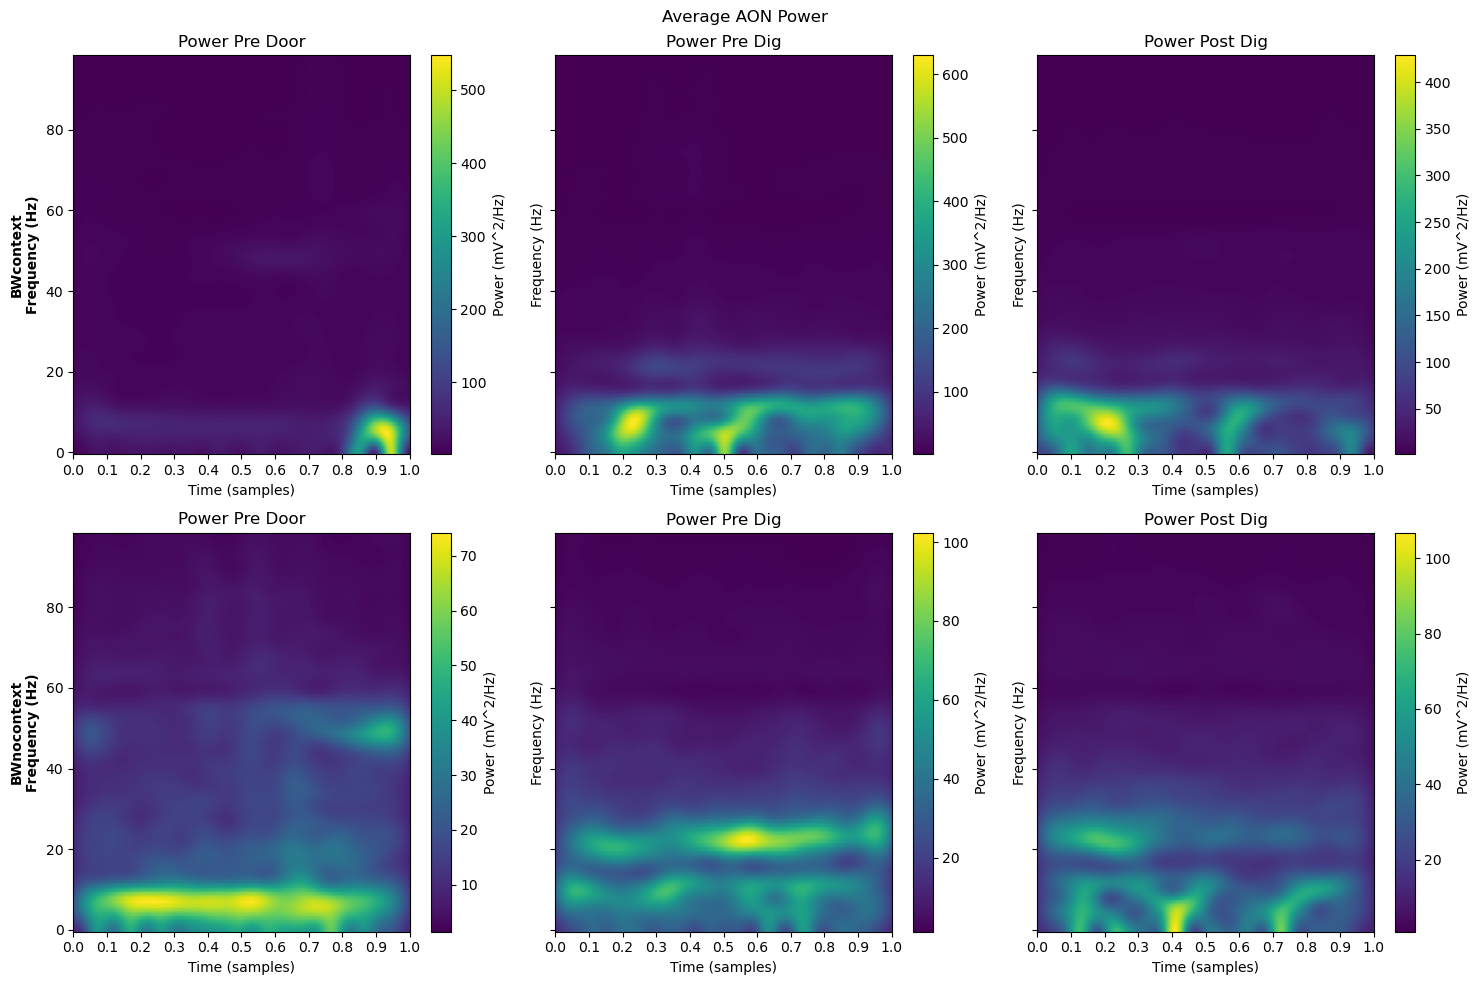


Task: BWcontext, Area: vHp, Rows in task_data: 15
0 power_pre_door BWcontext vHp
['LFP3_AON', 'LFP4_AON', 'LFP1_vHp', 'LFP2_vHp']
Data shape before mean: (2, 99, 2000)
Data shape after mean: (99, 2000)
['LFP4_AON', 'LFP1_vHp', 'LFP2_vHp']
Data shape before mean: (2, 99, 2000)
Data shape after mean: (99, 2000)
['LFP3_AON', 'LFP4_AON', 'LFP1_vHp', 'LFP2_vHp']
Data shape before mean: (2, 99, 2000)
Data shape after mean: (99, 2000)
['LFP1_AON', 'LFP3_AON', 'LFP4_AON', 'LFP1_vHp', 'LFP2_vHp']
Data shape before mean: (2, 99, 2000)
Data shape after mean: (99, 2000)
['LFP3_AON', 'LFP4_AON', 'LFP1_vHp', 'LFP2_vHp']
Data shape before mean: (2, 99, 2000)
Data shape after mean: (99, 2000)
['LFP3_AON', 'LFP4_AON', 'LFP1_vHp', 'LFP2_vHp']
Data shape before mean: (2, 99, 2000)
Data shape after mean: (99, 2000)
['LFP1_AON', 'LFP2_AON', 'LFP3_AON', 'LFP4_AON', 'LFP1_vHp', 'LFP2_vHp']
Data shape before mean: (2, 99, 2000)
Data shape after mean: (99, 2000)
['LFP1_AON', 'LFP2_AON', 'LFP3_AON', 'LFP4_AON'

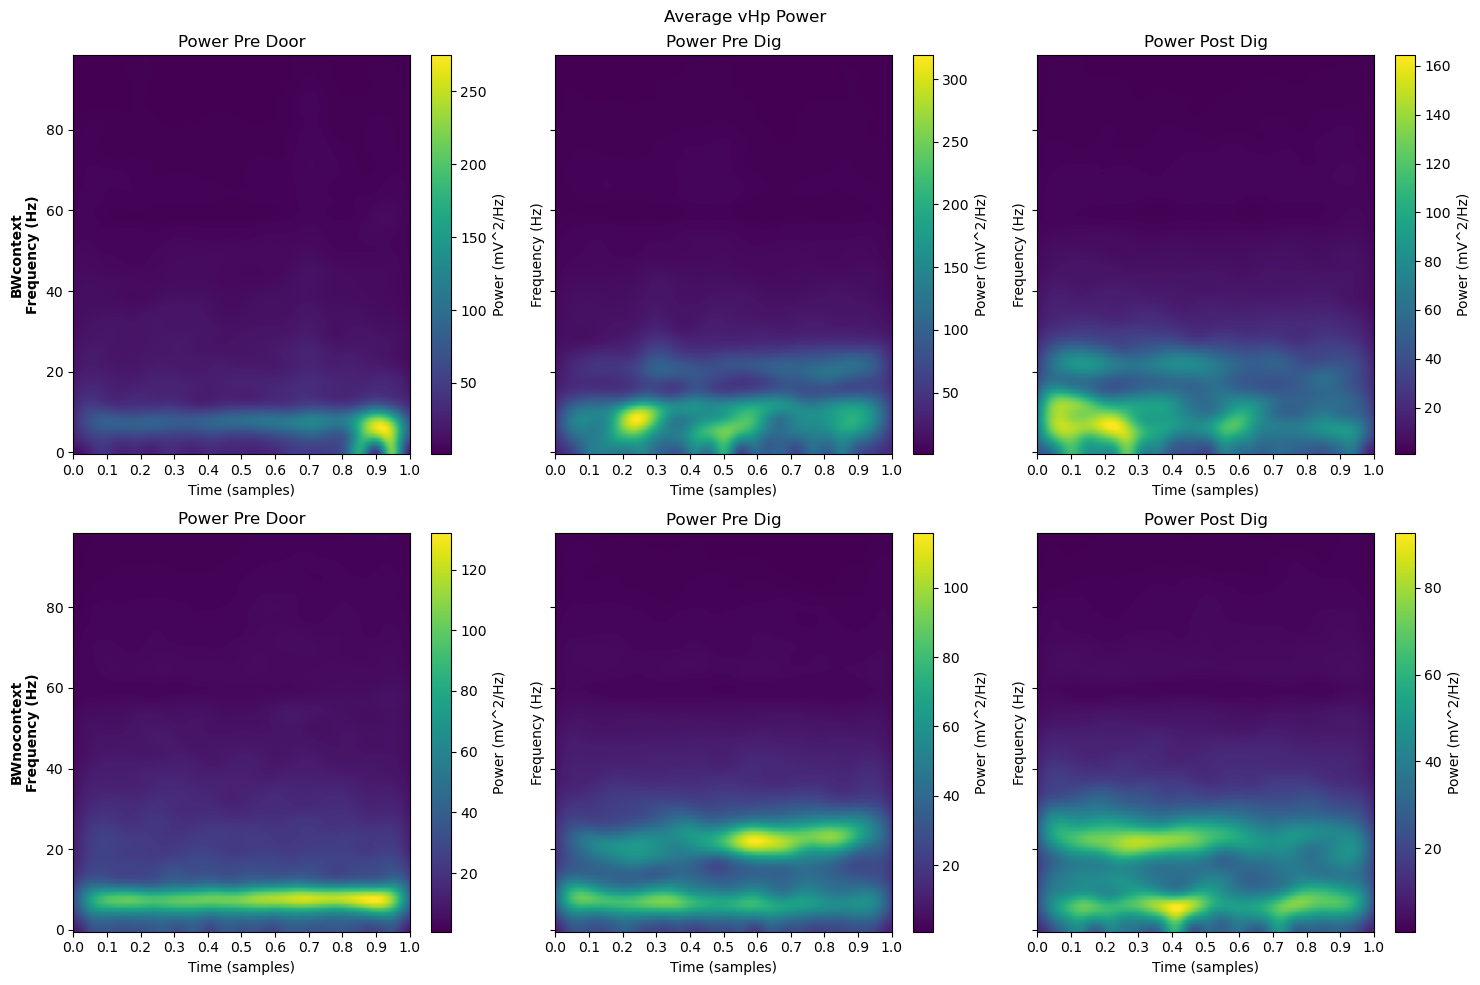

In [ ]:
results_df = pd.read_pickle(savepath+'marked_power_tfr_epochs_mrlt.pkl')

def make_averaged_power(epoch, area):
    print(epoch.ch_names)
    area_channels = [channel for channel in epoch.ch_names if area in channel]
    #print(area_channels)

    if len(area_channels)==0:
        print("Error")
        return None
    else:
        area_epoch = epoch.copy()
        area_epoch.pick(area_channels)
        averaged_epoch_power = area_epoch.average(dim='epochs')
        print(f"Data shape before mean: {averaged_epoch_power.shape}")  # DEBUG
        mean_ch_power = np.mean(averaged_epoch_power.get_data(), axis = 0)
        print(f"Data shape after mean: {mean_ch_power.shape}")  # DEBUG
        return mean_ch_power


for area in ["AON", "vHp"]:
    area_df = pd.DataFrame()
    fig, axs = plt.subplots(2,3, figsize= (15,10), sharey=True)
    fig.suptitle(f'Average {area} Power')
    for rowi, task in enumerate(["BWcontext", "BWnocontext"]):
        task_data=results_df[results_df['task']==task]
        print(f"\nTask: {task}, Area: {area}, Rows in task_data: {len(task_data)}")
        for coli, event in enumerate(['power_pre_door', 'power_pre_dig','power_post_dig']):
            print(coli,event, task, area)
            event_arrays = task_data[event].apply(lambda x: make_averaged_power(x, area))
            
            valid_arrays = [arr for arr in event_arrays.values if arr is not None]
            
            print(f"Valid arrays found: {len(valid_arrays)}")
            
            if len(valid_arrays) > 0:
                averaged_array = np.mean(np.stack(valid_arrays), axis=0)
                print(f"Averaged array shape: {averaged_array.shape}")
                
                ax = axs[rowi, coli]
                im = ax.imshow(X= averaged_array, cmap = 'viridis', aspect='auto', origin='lower')
                                # Add titles and labels
                ax.set_title(f'{event.replace("_", " ").title()}')
                ax.set_xlabel('Time (samples)')
                ax.set_ylabel('Frequency (Hz)')
                ax.set_xticks(list(np.arange(0,int(time_window*fs)+200,200)))
                ax.set_xticklabels(list(np.round(np.arange(0,time_window +0.1,0.1), decimals = 1)))
                # Add colorbar
                plt.colorbar(im, ax=ax, label='Power (mV^2/Hz)')
                
                # Add row labels
                if coli == 0:
                    ax.set_ylabel(f'{task}\nFrequency (Hz)', fontweight='bold')
                # Add your plotting code here
            else:
                print(f"WARNING: No valid data for {area}, {task}, {event}")
                ax = axs[rowi, coli]
                ax.text(0.5, 0.5, 'No data', ha='center', va='center')
    plt.tight_layout()
    fig.savefig(savepath+f'marked_power_spectrogram_{area}.png')
    plt.show()


# Coherence

## Average Coherogram pkl

In [ ]:
##############

time_window = 1
fs = 2000  # Sampling frequency
tanh_norm = True
###############

import numpy as np
import mne

def randomize_timepoints(epochs, seed=None):
    """Shuffle time points independently for each channel and epoch."""
    rng = np.random.default_rng(seed)
    data = epochs.get_data()
    randomized_data = data.copy()
    
    for epoch_idx in range(randomized_data.shape[0]):
        for channel_idx in range(randomized_data.shape[1]):
            rng.shuffle(randomized_data[epoch_idx, channel_idx, :])
    
    return mne.EpochsArray(randomized_data, epochs.info, 
                          events=epochs.events, tmin=epochs.tmin)

def coherogram_pkl(time_window, fs, tanh_norm, shuffle=False):
    if tanh_norm:
        suffix ='_normalized'
    else:
        suffix ='_non-normalized'

    if shuffle:
        shuffled = 'shuffled'
    else:
        shuffled =''

    con_data_df_clean = pd.read_pickle(savepath + f'marked_mne_epochs_array_{int(time_window*fs)}.pkl')
    event_list=['mne_epoch_door_before','mne_epoch_door_after','mne_epoch_dig_before','mne_epoch_dig_after']

    print(event_list)
    BWcontext_data=con_data_df_clean[(con_data_df_clean['task']=='BWcontext')]
    BWnocontext_data=con_data_df_clean[(con_data_df_clean['task']=='BWnocontext')]
    task_data_dict={'BWcontext':BWcontext_data,'BWnocontext':BWnocontext_data}

    all_con_data=[]
    all_con_data_mean=[]
    for task_num,task_name in enumerate(task_data_dict.keys()):
            task_data=task_data_dict[task_name]
            row=[task_name]
            #print(row)
            row_2=[task_name]
            for event in event_list:
                #print(event)
                event_epoch_list=task_data[event]
                aon_vHp_con=[]
                for event_epoch in event_epoch_list:
                        #print(row,event, event_epoch) 
                        if event_epoch.events.shape[0] <5:
                            print(f"Skipping {event} for {task_name} due to insufficient events")
                            continue
                        fmin=1
                        fmax=100
                        fs=2000
                        freqs = np.arange(fmin,fmax)
                        n_cycles = freqs/3
                        
                        if shuffle:
                            event_epoch = randomize_timepoints(event_epoch, seed=42) ### TURN ON FOR RANDOMIZING

                        con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),
                                                            mode='cwt_morlet', cwt_freqs=freqs,
                                                            cwt_n_cycles=n_cycles, verbose=False, fmin=fmin, fmax=fmax, faverage=False)
                        
                        coh = con.get_data(output='dense')
                        indices = con.names
                        
                        for i in range(coh.shape[0]):
                            for j in range(coh.shape[1]):
                                if 'AON' in indices[j] and 'vHp' in indices[i]:
                                    coherence= coh[i,j,:,:]
                                    if tanh_norm:
                                        coherence=np.arctanh(coherence)
                                    aon_vHp_con.append(coherence)
                row.append(np.mean(aon_vHp_con, axis=0))
                row_2.append(np.mean(aon_vHp_con))
            all_con_data.append(row)                    
            all_con_data_mean.append(row_2)
    # Convert all_con_data to a DataFrame for easier manipulation
    all_con_data_df = pd.DataFrame(all_con_data, columns=['task'] + event_list)
    all_con_data_df.to_pickle(savepath+'coherence_spectrogram_before_after_door_dig_truncated_{}{}{}.pkl'.format(int(time_window*fs), suffix, shuffled))

coherogram_pkl(time_window=time_window, fs=fs, tanh_norm=tanh_norm, shuffle=False)

## Average Coherogram plot

In [ ]:
##############

time_window = 1
fs = 2000  # Sampling frequency
tanh_norm = True
shuffle = False
###############

if tanh_norm:
    suffix ='_normalized'
else:
    suffix ='_non-normalized'

if shuffle:
    shuffled = '_shuffled'
else:
    shuffled =''

all_con_data_df=pd.read_pickle(savepath+'coherence_spectrogram_before_after_door_dig_truncated_{}{}{}.pkl'.format(int(time_window*fs), suffix, shuffled))
event_list=['mne_epoch_door_before','mne_epoch_dig_before','mne_epoch_dig_after']

times=np.arange(0, time_window, 1/fs)
fig, axs=plt.subplots(2,3, figsize=(15,10), sharey=True)
vmin = all_con_data_df[event_list].applymap(np.min).min().min()
vmax = all_con_data_df[event_list].applymap(np.max).max().max()
event_names=['Before Door','Before Dig','After Dig']

writer = pd.ExcelWriter(savepath + 'coh_events_spectrogram_averaged{}_{}ms{}.xlsx'.format(suffix,int(time_window*fs/2), shuffled))


for i, event in enumerate(event_list):
    axs[0,i].imshow(all_con_data_df[event][0], extent=[times[0], times[-1], 1, 100],
                   aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
    axs[0,i].set_xlabel('Time (s)')
    axs[0,i].set_ylabel('Frequency (Hz)')
    axs[0,i].set_title(event_names[i])

    axs[1,i].imshow(all_con_data_df[event][1], extent=[times[0], times[-1], 1, 100],
                   aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
    axs[1,i].set_xlabel('Time (s)')
    axs[1,i].set_ylabel('Frequency (Hz)')
    axs[1,i].set_title(event_names[i])
    axs[0,0].text(-0.3, 0.5, 'Context', transform=axs[0,0].transAxes, fontsize=14, verticalalignment='center', rotation=90)
    axs[1,0].text(-0.3, 0.5, 'No Context', transform=axs[1,0].transAxes, fontsize=14, verticalalignment='center', rotation=90)
    
    print(all_con_data_df[event][0].shape)
    
    freqs = [f'{int(freq)}Hz' for freq in np.linspace(1, 100, all_con_data_df[event][0].shape[0])]
    freqs.insert(0, 'Frequency (Hz) / Time (s)')
    print(len(freqs))
    time_points = [f'{np.round(t, 3)}s' for t in np.linspace(0, time_window, all_con_data_df[event][0].shape[1])]

    df_context = pd.DataFrame(all_con_data_df[event][0])
    df_context.loc[-1] = time_points  # Add time points as the first row
    df_context.index = df_context.index + 1  # Shift index
    df_context = df_context.sort_index()
    df_context.insert(0, 'Frequency (Hz)/ Time (s)', freqs)
    df_context.to_excel(writer, sheet_name=f'{event_names[i]}_Context', index=False)

    df_nocontext = pd.DataFrame(all_con_data_df[event][1])
    df_nocontext.loc[-1] = time_points  # Add time points as the first row
    df_nocontext.index = df_nocontext.index + 1  # Shift index
    df_nocontext = df_nocontext.sort_index()
    df_nocontext.insert(0, 'Frequency (Hz)/ Time (s)', freqs)
    df_nocontext.to_excel(writer, sheet_name=f'{event_names[i]}_NoContext', index=False)
    
    # Add a colorbar
writer.close()
cbar = fig.colorbar(axs[0,0].images[0], ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Z-Coherence (A.U.)', fontsize=12)
fig.savefig(savepath+f'coh_events_spectrogram_averaged{suffix}_{int(time_window*fs/2)}ms{shuffled}.png', dpi=300, bbox_inches='tight')
plt.show()

## Boxplot pkl


In [ ]:
#############

time_window = 1
fs=2000
tanh_norm = True
##############

importlib.reload(coherence_functions)


def coherence_boxplot_pkl(time_window, fs, tanh_norm):

    importlib.reload(coherence_functions)

    if tanh_norm:
        suffix ='normalized'
    else:
        suffix ='nonnormalized'

    con_data_df_clean = pd.read_pickle(savepath + f'marked_mne_epochs_array_{int(time_window*fs)}.pkl')

    con_data_df_clean['coherence_door_before']=con_data_df_clean['mne_epoch_door_before'].apply(lambda x: coherence_functions.convert_epoch_to_coherence_mt(x, tanh_norm=tanh_norm))
    con_data_df_clean['coherence_door_after']=con_data_df_clean['mne_epoch_door_after'].apply(lambda x: coherence_functions.convert_epoch_to_coherence_mt(x, tanh_norm=tanh_norm))
    con_data_df_clean['coherence_dig_before']=con_data_df_clean['mne_epoch_dig_before'].apply(lambda x: coherence_functions.convert_epoch_to_coherence_mt(x, tanh_norm=tanh_norm))
    con_data_df_clean['coherence_dig_after']=con_data_df_clean['mne_epoch_dig_after'].apply(lambda x: coherence_functions.convert_epoch_to_coherence_mt(x, tanh_norm=tanh_norm))
    con_data_df_clean.drop(columns=['mne_epoch_door_before','mne_epoch_door_after','mne_epoch_dig_before','mne_epoch_dig_after'], inplace=True)
    con_data_df_clean.to_pickle(savepath+f'coherence_boxplot_mt_{int(fs*time_window)}_{suffix}.pkl')

    con_data_df_shuffled = pd.read_pickle(savepath + f'marked_mne_epochs_array_{int(time_window*fs)}.pkl')
    
    con_data_df_shuffled['coherence_door_before']=con_data_df_shuffled['mne_epoch_door_before'].apply(lambda x: coherence_functions.convert_epoch_to_coherence_mt(x,tanh_norm=tanh_norm, shuffle=True))
    con_data_df_shuffled['coherence_door_after']=con_data_df_shuffled['mne_epoch_door_after'].apply(lambda x: coherence_functions.convert_epoch_to_coherence_mt(x,tanh_norm=tanh_norm, shuffle=True))
    con_data_df_shuffled['coherence_dig_before']=con_data_df_shuffled['mne_epoch_dig_before'].apply(lambda x: coherence_functions.convert_epoch_to_coherence_mt(x,tanh_norm=tanh_norm, shuffle=True))
    con_data_df_shuffled['coherence_dig_after']=con_data_df_shuffled['mne_epoch_dig_after'].apply(lambda x: coherence_functions.convert_epoch_to_coherence_mt(x,tanh_norm=tanh_norm, shuffle=True))
    con_data_df_shuffled.drop(columns=['mne_epoch_door_before','mne_epoch_door_after','mne_epoch_dig_before','mne_epoch_dig_after'], inplace=True)
    con_data_df_shuffled.to_pickle(savepath+f'coherence_boxplot_mt_shuffled_{int(fs*time_window)}_{suffix}.pkl')

coherence_boxplot_pkl(time_window=time_window, fs=fs, tanh_norm=tanh_norm)

## Boxplot plot

normalized


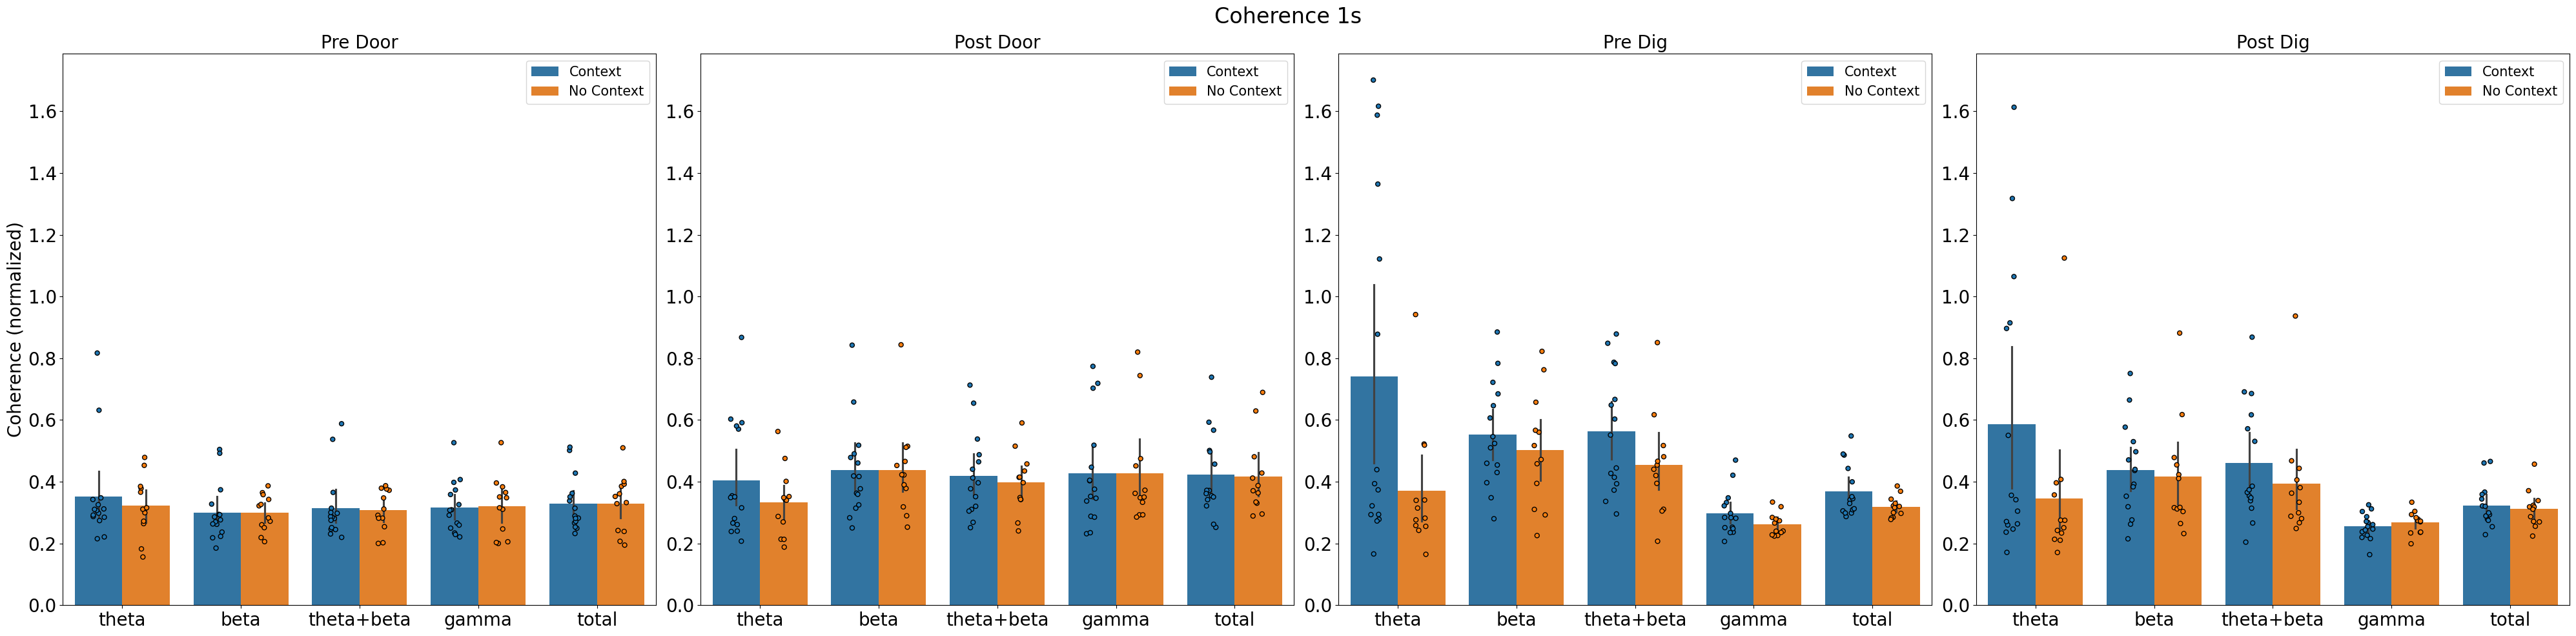

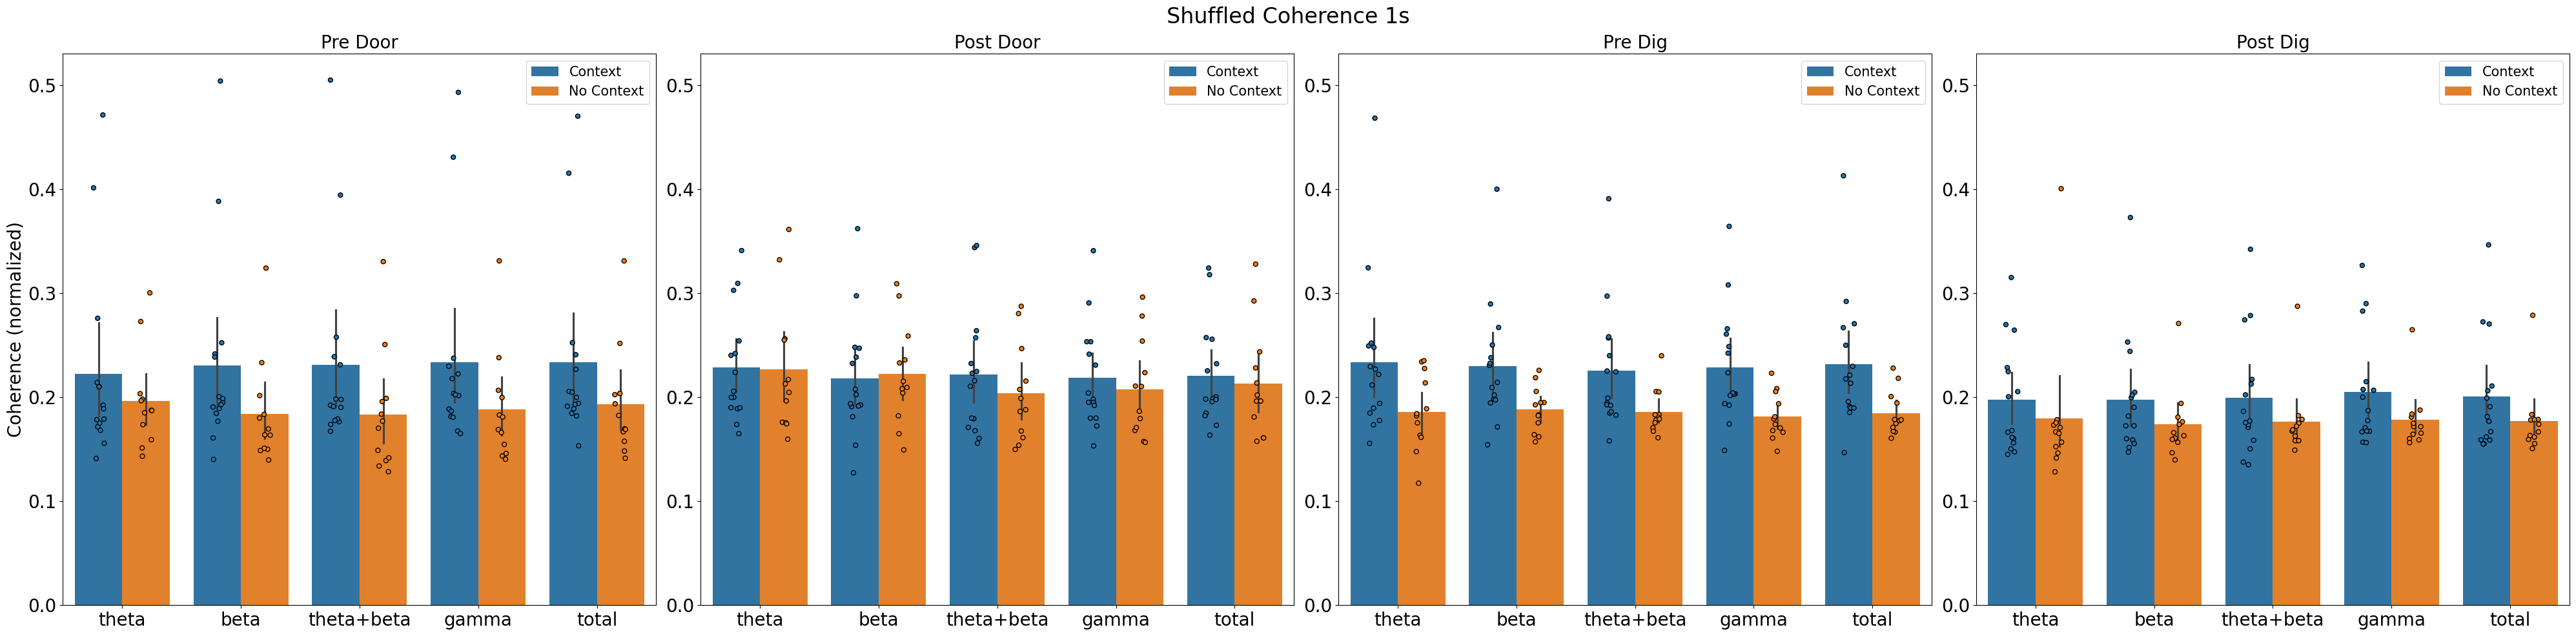

In [27]:
###################

time_window = 1
fs=2000
tanh_norm = True
###################
def plot_coherence_boxplot(time_window, fs, tanh_norm):
    importlib.reload(coherence_functions)
    if tanh_norm:
        suffix ='normalized'
    else:
        suffix ='nonnormalized'
    print(suffix)

    con_data_df_clean=pd.read_pickle(savepath+f'coherence_boxplot_mt_{int(fs*time_window)}_{suffix}.pkl')
    fig, axs = plt.subplots(1, 4, figsize=(40, 10), sharey=True)
    fig.suptitle(f'Coherence {time_window}s', fontsize=24)
    axs = axs.flatten()
    for ax in axs:
        ax.tick_params(axis='y', which='both', labelleft=True)
    writer=pd.ExcelWriter(savepath + f'\\coh_events_perband_averaged_{suffix}_{int(time_window*fs/2)}ms.xlsx')
    events_dict={'coherence_door_before':'Pre Door', 'coherence_door_after': 'Post Door', 'coherence_dig_before':'Pre Dig', 'coherence_dig_after':'Post Dig'}
    task_dict={'BWcontext':'Context','BWnocontext':'No Context'}
    band_order = ['theta', 'beta','theta+beta', 'gamma', 'total']
    for i, event in enumerate(events_dict.keys()):
        event_data = con_data_df_clean[event]
        event_data_df = pd.DataFrame(event_data.tolist())
        event_data_df.reset_index(drop=True, inplace=True)
        event_data_df['rat_id'] = con_data_df_clean['rat_id'].reset_index(drop=True)
        event_data_df['task'] = con_data_df_clean['task'].reset_index(drop=True)
        event_data_df_melted = pd.melt(event_data_df, id_vars=['rat_id', 'task'], value_vars=band_order, var_name='band', value_name='coherence')
        sns.barplot(x='band', y='coherence', hue='task', hue_order=['BWcontext', 'BWnocontext'], data=event_data_df_melted, legend=True, ax=axs[i])
        sns.stripplot(x='band', y='coherence', hue='task', hue_order=['BWcontext', 'BWnocontext'], data=event_data_df_melted, dodge=True, edgecolor='black', linewidth=1, jitter=True, legend=False, ax=axs[i])
        #axs[i].set_xticklabels(['Total', 'Theta', 'Beta', 'Gamma'])
        handles, labels = axs[i].get_legend_handles_labels()
        axs[i].legend(handles, [task_dict[l] for l in labels], loc='upper right', fontsize=15)
        axs[i].set_title(f'{events_dict[event]}', fontsize=20)
        if i == 0:
            axs[i].set_ylabel(f'Coherence ({suffix})', fontsize=20)
        else:
            axs[i].set_ylabel('')
        axs[i].set_xlabel('')
        axs[i].tick_params(axis='both', which='major', labelsize=20)
        event_data_df_melted.to_excel(writer, sheet_name=event)
    writer.close()
    fig.savefig(savepath+f'coh_events_perband_averaged_{suffix}_{int(time_window*fs/2)}ms.png', format='png',dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

    """Shuffled coherence boxplot per band"""


    con_data_df_shuffled=pd.read_pickle(savepath+f'coherence_boxplot_mt_shuffled_{int(fs*time_window)}_{suffix}.pkl')
    fig, axs = plt.subplots(1, 4, figsize=(40, 10), sharey=True)
    fig.suptitle(f'Shuffled Coherence {time_window}s', fontsize=24)
    axs = axs.flatten()
    for ax in axs:
        ax.tick_params(axis='y', which='both', labelleft=True)
    writer=pd.ExcelWriter(savepath + f'\\coh_events_perband_averaged_{suffix}_{int(time_window*fs/2)}ms_shuffled.xlsx')
    events_dict={'coherence_door_before':'Pre Door', 'coherence_door_after': 'Post Door', 'coherence_dig_before':'Pre Dig', 'coherence_dig_after':'Post Dig'}
    for i, event in enumerate(events_dict.keys()):
        event_data = con_data_df_shuffled[event]
        event_data_df = pd.DataFrame(event_data.tolist())
        event_data_df.reset_index(drop=True, inplace=True)
        event_data_df['rat_id'] = con_data_df_shuffled['rat_id'].reset_index(drop=True)
        event_data_df['task'] = con_data_df_shuffled['task'].reset_index(drop=True)
        event_data_df_melted = pd.melt(event_data_df, id_vars=['rat_id', 'task'], value_vars=band_order, var_name='band', value_name='coherence')
        sns.barplot(x='band', y='coherence', hue='task', hue_order=['BWcontext', 'BWnocontext'], data=event_data_df_melted, legend=True, ax=axs[i])
        sns.stripplot(x='band', y='coherence', hue='task', hue_order=['BWcontext', 'BWnocontext'], data=event_data_df_melted, dodge=True, edgecolor='black', linewidth=1, jitter=True, legend=False, ax=axs[i])
        #axs[i].set_xticklabels(['Total', 'Theta', 'Beta', 'Gamma'])
        handles, labels = axs[i].get_legend_handles_labels()
        axs[i].legend(handles, [task_dict[l] for l in labels], loc='upper right', fontsize=15)

        axs[i].set_title(f'{events_dict[event]}', fontsize=20)
        if i == 0:
            axs[i].set_ylabel(f'Coherence ({suffix})', fontsize=20)
        else:
            axs[i].set_ylabel('')
        axs[i].set_xlabel('')
        axs[i].tick_params(axis='both', which='major', labelsize=20)
        event_data_df_melted.to_excel(writer, sheet_name=event)
    writer.close()
    fig.savefig(savepath+f'coh_events_perband_averaged_{suffix}_{int(time_window*fs/2)}ms_shuffled.png', format='png',dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

plot_coherence_boxplot(time_window=time_window, fs=fs, tanh_norm=tanh_norm)
